# GOAL : 根據人們的個人資料，判斷其年收入是否高於 50,000 美元。
## Method1 : logistic regression

In [11]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
np.random.seed(0)

## 資料前處理
- X_train 有經過one-hot encoding處理 所以有510行columns  [[參考資料]](https://medium.com/@PatHuang/初學python手記-3-資料前處理-label-encoding-one-hot-encoding-85c983d63f87)
- [字串格式化參考資料](https://blog.techbridge.cc/2019/05/03/how-to-use-python-string-format-method/)

In [12]:
train_x_path = './data/X_train'
train_y_path = './data/Y_train'
test_x_path = './data/X_test'
output_path = './output_{}.csv'

# parse csv files to numpy array
with open(train_x_path) as f:
    # 跳過 column names
    next(f) 
    # strip 去除頭尾指定字元
    # 從[1:] 開始是因為id 不需要 
    x_train = np.array([line.strip('\n').split(',')[1:] for line in f] , dtype = float )

with open(train_y_path) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1] for line in f] , dtype = float )

with open(test_x_path) as f:
    next(f)
    x_test = np.array([line.strip('\n').split(',')[1:] for line in f] , dtype = float )

## Normorlize

In [13]:
def _normorlize(X,train = True , specified_column = None, X_mean=None, X_std= None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data
    
    if specified_column==None:
        specified_column = np.arange(x_train.shape[1])
    if train:
        X_mean = np.mean(X[: , specified_column] , axis = 0).reshape(1,-1)
        X_std = np.std(X[: , specified_column] , axis = 0).reshape(1,-1)
    
    X[: ,specified_column] = (X[: ,specified_column] - X_mean) / (X_std + 1e-8)
    
    return X , X_mean ,X_std

## Split into train_set and dev_set

In [14]:
def _train_dev_split(X,Y,dev_ratio = 0.25):
    train_size = int(X.shape[0] * (1-dev_ratio))
    return X[:train_size] ,Y[:train_size] , X[train_size:] , Y[train_size:]

## Normorlize and Split

In [15]:
# Normorlize X_train & X_test
X_train , X_mean, X_std = _normorlize(x_train,train=True)
X_test,_ ,_ = _normorlize(x_test , train=False , specified_column=None,X_mean= X_mean ,X_std=X_std)

# Split into train and dev
dev_ratio = 0.1
X_train , Y_train , X_dev , Y_dev = _train_dev_split(X_train,y_train , dev_ratio=dev_ratio)

train_size = X_train.shape[0]
dev_size = X_dev.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]

print('train_size = {}'.format(train_size))
print('dev_size = {}'.format(dev_size))
print('test_size = {}'.format(test_size))
print('data_dim = {}'.format(data_dim))

train_size = 48830
dev_size = 5426
test_size = 27622
data_dim = 510


## Some Useful Functions

In [7]:
def _shuffle(X,Y):
    randomize = np.arange(X.shape[0])
    np.random.shuffle(randomize)
    return (X[randomize],Y[randomize])

def _sigmod(z):
    # Sigmoid function can be used to calculate probability.
    # To avoid overflow, minimum/maximum output value is set.
    # clip (input,最小值,最大值)
    return np.clip(1 / (1.0 + np.exp(-z)) , 1e-8 , 1 - (1e-8))

def _f(X,w,b):
    # This is the logistic regression function, parameterized by w and b
    #
    # Arguements:
    #     X: input data, shape = [batch_size, data_dimension]
    #     w: weight vector, shape = [data_dimension, ]
    #     b: bias, scalar
    # Output:
    #     predicted probability of each row of X being positively labeled, shape = [batch_size, ]
    return _sigmod(np.matmul(X,w) + b)

def _prdeic(X, w, b):
    # This function returns a truth value prediction for each row of X 
    # by rounding the result of logistic regression function.
    return np.round(_f(X,w,b)).astype(np.int)

def _accurcy(Y_prdic , Y_label):
    # This function calculates prediction accuracy
    acc = 1 - np.mean(np.abs(Y_prdic - Y_label))
    return acc

## Function about gradient and loss
- _Gradient 公式：https://i.imgur.com/0V3ecav.png
- _Cross_entropy_loss 公式 ：https://i.imgur.com/kTPEcda.png

In [8]:
def _cross_entropy_loss(y_pred, Y_label):
    # This function computes the cross entropy.
    #
    # Arguements:
    #     y_pred: probabilistic predictions, float vector
    #     Y_label: ground truth labels, bool vector
    # Output:
    #     cross entropy, scalar
    cross_entropy = -np.dot(Y_label,np.log(y_pred)) - np.dot((1-Y_label),np.log(1-y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    y_pred = _f(X,w,b)
    pred_error = Y_label - y_pred
    w_grad = -np.sum(pred_error * X.T , 1) # 此處並非矩陣乘法 而是將X.T(510*8) 每行都乘上 pred_error對應的行 如下例
    b_grad = -np.sum(pred_error) 
    return w_grad, b_grad

In [118]:
A = np.array([[1, 2, 6], [3, 4, 9]])
B = np.array([2,3,3])
print (A*B)

[[ 2  6 18]
 [ 6 12 27]]


## Training
我們使用小批次梯度下降法來訓練。訓練資料被分為許多小批次，針對每一個小批次，我們分別計算其梯度以及損失，並根據該批次來更新模型的參數。當一次迴圈完成，也就是整個訓練集的所有小批次都被使用過一次以後，我們將所有訓練資料打散並且重新分成新的小批次，進行下一個迴圈，直到事先設定的迴圈數量達成為止。

In [131]:
# initial weight and bias
w = np.zeros((data_dim,))
b = np.zeros((1,))

# some parameters for taining
max_iter = 10
batch_size = 8
learning_rate = 0.2

# keep the loss and accuracy every iteration for plotting
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []

# calcuate the number of parameter updates
step = 1

# interative training
for epoch in range(max_iter):
    # shuffle each epoch
    X_train , Y_train = _shuffle(X_train,Y_train)
    
    # mini-batch training
    for idx in range(int(np.floor(train_size / batch_size))):
        X = X_train[idx*batch_size : (idx+1)*batch_size]
        Y = Y_train[idx*batch_size : (idx+1)*batch_size]
        
        # Compute the gradient
        w_grad, b_grad = _gradient(X, Y, w, b)
        
        # gradient descent update
        # learning rate decay with time
        w = w - learning_rate/np.sqrt(step) * w_grad
        b = b - learning_rate/np.sqrt(step) * b_grad
        
        step += 1
        
    # Compute loss and acc of training set and devlopment set
    y_train_pred = _f(X_train, w, b)
    Y_train_pred = np.round(y_train_pred)
    train_acc.append(_accurcy(Y_train_pred,Y_train))
    train_loss.append(_cross_entropy_loss(y_train_pred,Y_train) / train_size)
    
    y_dev_pred = _f(X_dev, w, b)
    Y_dev_pred = np.round(y_dev_pred)
    dev_acc.append(_accurcy(Y_dev_pred,Y_dev))
    dev_loss.append(_cross_entropy_loss(y_dev_pred,Y_dev) / dev_size)
    
print('Training loss : {}'.format(train_loss[-1]))
print('Development loss : {}'.format(dev_loss[-1]))
print('Training acuracy : {}'.format(train_acc[-1]))
print('Development acc : {}'.format(dev_acc[-1]))



Training loss : 0.276973843065285
Development loss : 0.301183017552779
Training acuracy : 0.8836166291214418
Development acc : 0.8759675635827497


## Plotting loss and accuracy curve

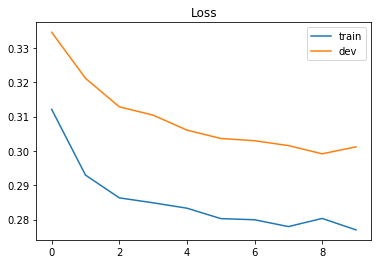

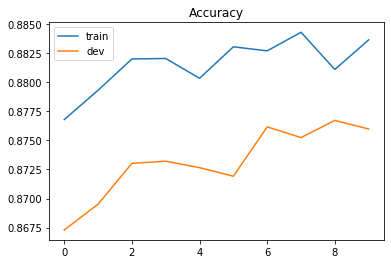

In [132]:
import matplotlib.pyplot as plt

#Loss curve
plt.plot(train_loss)
plt.plot(dev_loss)
plt.title('Loss')
plt.legend(['train','dev'])
plt.show()

#Acc curve
plt.plot(train_acc)
plt.plot(dev_acc)
plt.title('Accuracy')
plt.legend(['train','dev'])
plt.show()



## Predicting test labels
預測測試集的資料標籤並且存在output_logistic.csv中

In [133]:
predictions = _prdeic(X_test, w, b)
with open (output_path.format('logistic') , 'w') as f:
    f.write('id,label\n')
    for i , label in enumerate(predictions):
        f.write('{},{}\n'.format(i,label))
        
# print out the most significant weights
# argsort() function return the indices
ind = np.argsort(np.abs(w))[::-1]
with open (test_x_path) as f:
    features = f.readline().strip('\n').split(',')
features = np.array(features)
for i in ind[:10]:
    print(features[i],w[i])

 Householder -1.3130822885335887
 Unemployed full-time 1.1502967218774525
 Other Rel 18+ spouse of subfamily RP -1.003228743256259
 El-Salvador -0.9568946790736724
 Other relative of householder -0.9538275822171146
 12th grade no diploma -0.9351356219192601
 1 0.8414680641857574
 El-Salvador -0.8372423228092736
 Child under 18 ever married -0.756572323731449
dividends from stocks -0.7103244084887601


## Method2 : generative model

## Preparing data 
訓練集與測試集的處理方法跟 logistic regression 一模一樣，然而因為 generative model 有可解析的最佳解，因此不必使用到 development set。

In [16]:
with open (train_x_path) as f:
    next(f)
    x_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

with open (train_y_path) as f:
    next(f)
    y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)

with open (test_x_path) as f:
    next(f)
    x_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

## Normorliz train set and test set 

In [17]:
x_train , x_mean ,x_std = _normorlize(x_train , train=True)
x_test , _ , _ = _normorlize(x_test, train=False, X_mean=x_mean , X_std=x_std)

## Mean and Covariance 
- 在 generative model 中，我們需要分別計算兩個類別內的資料平均與共變異。
- 公式 ： https://i.imgur.com/02ZBI9k.png
- shared covariance : https://i.imgur.com/6QiE8S7.png

In [20]:
x_train_0 = np.array([x for x, y in zip(x_train,y_train) if y == 0])
x_train_1 = np.array([x for x, y in zip(x_train,y_train) if y == 1])

mean_0 = np.mean(x_train_0 , axis=0)
mean_1 = np.mean(x_train_1 , axis=0)

# compute in-class covariance
cov_0 = np.zeros((data_dim,data_dim))
cov_1 = np.zeros((data_dim,data_dim))

for x in x_train_0:
    cov_0 += np.dot(np.transpose([x - mean_0]) ,[x - mean_0]) / x_train_0.shape[0] 

for x in x_train_1:
    cov_1 += np.dot(np.transpose([x - mean_1]) ,[x - mean_1]) / x_train_1.shape[0] 

# shared covariance is taken as a weighted average of individual in-class covariance
cov = (cov_0 * x_train_0.shape[0] + cov_1 * x_train_1.shape[0]) / (x_train_0.shape[0] + x_train_1.shape[0])

## Computing weight and bias
- 公式 ： https://i.imgur.com/iAXAVNA.png

In [21]:
# Compute inverse of covariance matrix.
# Since covariance matrix may be nearly singular, np.linalg.inv() may give a large numerical error.
# Via SVD decomposition, one can get matrix inverse efficiently and accurately.
u, s, v = np.linalg.svd(cov, full_matrices=False)
inv = np.matmul(v.T * 1 / s, u.T)

# Directly compute weights and bias 
w = np.dot(inv , mean_0 - mean_1)
b = (-0.5) * np.dot(mean_0, np.dot(inv, mean_0)) + 0.5 * np.dot(mean_1, np.dot(inv, mean_1))\
    + np.log(float(x_train_0.shape[0]) / x_train_1.shape[0]) 

# compute accuracy on training set
pred_train = 1 - _prdeic(x_train, w, b)
acc = _accurcy(pred_train, y_train)
print(acc)

0.8686781185491006


## Predict test label
預測測試集的資料標籤並且存在 output_generative.csv 中

In [27]:
predictions = 1 - _prdeic(x_test,w,b)
with open(output_path.format('generative') ,'w') as f:
    f.write('id,label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i,label))

# Print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(test_x_path) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

 Utilities and sanitary services -11.40625
 Construction 10.892578125
 35 -10.5810546875
 Finance insurance and real estate 9.9375
 19 9.875
 Transportation -9.8671875
 Machine operators assmblrs & inspctrs -9.609375
 24 9.578125
 7 -9.5390625
 44 9.203125
